# Day 7: DDPM Sampling Playground

Interactive exploration of DDPM sampling with trained models from Day 6.

## 🎯 Learning Goals
- Understand the ancestral sampling procedure step-by-step
- Explore different variance schedules and their effects
- Visualize the reverse denoising process T→0
- Compare sample quality across training checkpoints
- Experiment with DDIM fast sampling


In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
from pathlib import Path

# Project imports
from src.utils import set_seed, get_device
from src.ddpm_schedules import DDPMSchedules
from src.models.unet_small import create_unet_small
from src.checkpoints import CheckpointManager
from src.sampler import DDPMSampler, create_sampler
from src.visualize import quick_grid, quick_trajectory, reverse_trajectory_grid
from src.quality import QualityEvaluator, load_dataset_samples

# Setup
set_seed(42)
device = get_device()
print(f"Using device: {device}")


Using device: cuda


## 🔧 Configuration Setup

Load configuration and set up model architecture.


In [2]:
# Load configuration (choose dataset)
dataset = "mnist"  # Change to "cifar10" if desired
config_path = f"../configs/{dataset}.yaml"

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"Dataset: {config['data']['dataset']}")
print(f"Diffusion steps: {config['diffusion']['T']}")
print(f"Schedule: {config['diffusion']['schedule']}")
print(f"Model channels: {config['model']['in_ch']}")
print(f"Checkpoints: {config['checkpoints']['list']}")


Configuration loaded:
Dataset: mnist
Diffusion steps: 1000
Schedule: cosine
Model channels: 1
Checkpoints: ['epoch_10.pt', 'epoch_30.pt', 'epoch_60.pt', 'ema.pt']


In [3]:
# Create model and sampler
model = create_unet_small(config)
model.to(device)
model.eval()

sampler = create_sampler(model, config, device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Sampler ready with {sampler.T} timesteps")


Model created with 4622593 parameters
Sampler ready with 1000 timesteps


## 📁 Checkpoint Management

Set up checkpoint manager and explore available checkpoints.

**Note**: This section requires trained checkpoints from Day 6. If you don't have them, you can still run the sampling demos with randomly initialized weights for demonstration purposes.


In [4]:
# Setup checkpoint manager (optional - requires Day 6 checkpoints)
ckpt_config = config['checkpoints']

try:
    ckpt_manager = CheckpointManager(
        ckpt_dir=ckpt_config['dir'],
        ckpt_list=ckpt_config['list'],
        use_ema=ckpt_config.get('use_ema', True),
        device=device
    )
    
    # Show checkpoint info
    print("Available checkpoints:")
    checkpoint_info = ckpt_manager.get_checkpoint_info()
    for info in checkpoint_info:
        print(f"  {info['index']}: {info['filename']} (epoch {info['epoch']}, {info['size_mb']:.1f}MB)")
    
    checkpoints_available = True
except FileNotFoundError as e:
    print("No Day 6 checkpoints found - will use randomly initialized model for demonstration")
    print(f"Expected checkpoints in: {ckpt_config['dir']}")
    checkpoints_available = False


Resolving checkpoints in: ../Day_06_Full_DDPM_Training_Loop/outputs/ckpts
  ✗ Missing: epoch_10.pt
  ✗ Missing: epoch_30.pt
  ✗ Missing: epoch_60.pt
  ✗ Missing: ema.pt
No Day 6 checkpoints found - will use randomly initialized model for demonstration
Expected checkpoints in: ../Day_06_Full_DDPM_Training_Loop/outputs/ckpts


## 🎲 Basic Sampling

Generate samples using ancestral DDPM sampling.


In [5]:
# Load a checkpoint if available
if checkpoints_available:
    ckpt_idx = -1  # -1 for latest, 0 for first, etc.
    metadata = ckpt_manager.load_checkpoint_into_model(model, ckpt_idx)
    
    print(f"Loaded checkpoint: {metadata['checkpoint_path']}")
    print(f"Epoch: {metadata.get('epoch', 'unknown')}")
    print(f"EMA used: {metadata.get('ema_used', False)}")
else:
    print("Using randomly initialized model (for demonstration purposes)")
    metadata = {'epoch': 'random'}


Using randomly initialized model (for demonstration purposes)


Generating 16 samples...


DDPM Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 82.75it/s, t=0, x_mean=5892.859, x_std=67417.867] 


Generated samples shape: torch.Size([16, 1, 28, 28])
Sample range: [-275016.625, 270747.031]


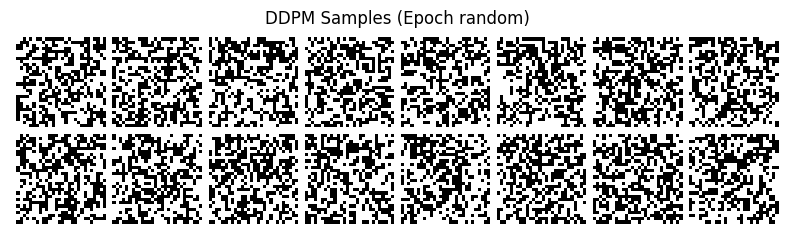

In [7]:
# Generate a batch of samples
num_samples = 16
if dataset == "mnist":
    img_shape = (1, 28, 28)
else:  # cifar10
    img_shape = (3, 32, 32)

shape = (num_samples, *img_shape)

print(f"Generating {num_samples} samples...")
results = sampler.sample(shape, progress=True)
samples = results['samples']

print(f"Generated samples shape: {samples.shape}")
print(f"Sample range: [{samples.min():.3f}, {samples.max():.3f}]")

# Display samples
quick_grid(samples, title=f"DDPM Samples (Epoch {metadata.get('epoch', '?')})")


## 🎬 Trajectory Visualization

Generate and visualize the complete reverse trajectory T→0.


In [8]:
# Generate single sample trajectory
print("Generating complete trajectory...")
trajectory_results = sampler.sample_single_trajectory(
    shape=(1, *img_shape),
    record_every=50,  # Record every 50 steps
    progress=True
)

trajectory = trajectory_results['trajectory']
trajectory_steps = trajectory_results['trajectory_steps']
x0_preds = trajectory_results['x0_preds']

print(f"Trajectory recorded: {len(trajectory)} frames")
print(f"Timesteps: {trajectory_steps[:5]}...{trajectory_steps[-5:]}")


Generating complete trajectory...


DDPM Sampling: 100%|██████████| 1000/1000 [00:11<00:00, 85.70it/s, t=0, x_mean=5560.223, x_std=66379.898] 

Trajectory recorded: 20 frames
Timesteps: [950, 900, 850, 800, 750]...[200, 150, 100, 50, 0]


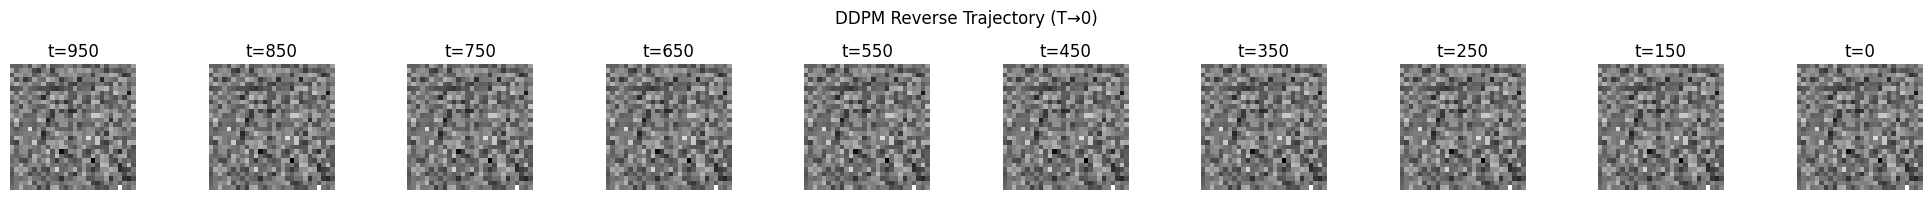

In [9]:
# Quick trajectory view
quick_trajectory(trajectory, trajectory_steps, sample_idx=0, 
                title="DDPM Reverse Trajectory (T→0)")


## ⚡ DDIM Fast Sampling

Experiment with DDIM for faster sampling with fewer steps.


In [10]:
# Compare DDPM vs DDIM sampling
num_steps_options = [50, 100, 1000]  # DDIM steps vs full DDPM
sampling_methods = {}

for num_steps in num_steps_options:
    print(f"Generating samples with {num_steps} steps...")
    
    if num_steps == 1000:
        # Full DDPM
        results = sampler.sample(
            shape=(4, *img_shape),
            ddim=False,
            progress=False
        )
        method_name = f"DDPM ({num_steps})"
    else:
        # DDIM
        results = sampler.sample(
            shape=(4, *img_shape),
            ddim=True,
            num_steps=num_steps,
            ddim_eta=0.0,  # Deterministic
            progress=False
        )
        method_name = f"DDIM ({num_steps})"
    
    sampling_methods[method_name] = results['samples']
    
    # Print timing info
    info = results['sampling_info']
    print(f"  Actual steps used: {info['num_steps']}")

print("\\nDDIM can achieve similar quality with much fewer steps!")


Generating samples with 50 steps...
  Actual steps used: 50
Generating samples with 100 steps...
  Actual steps used: 100
Generating samples with 1000 steps...
  Actual steps used: 1000
\nDDIM can achieve similar quality with much fewer steps!


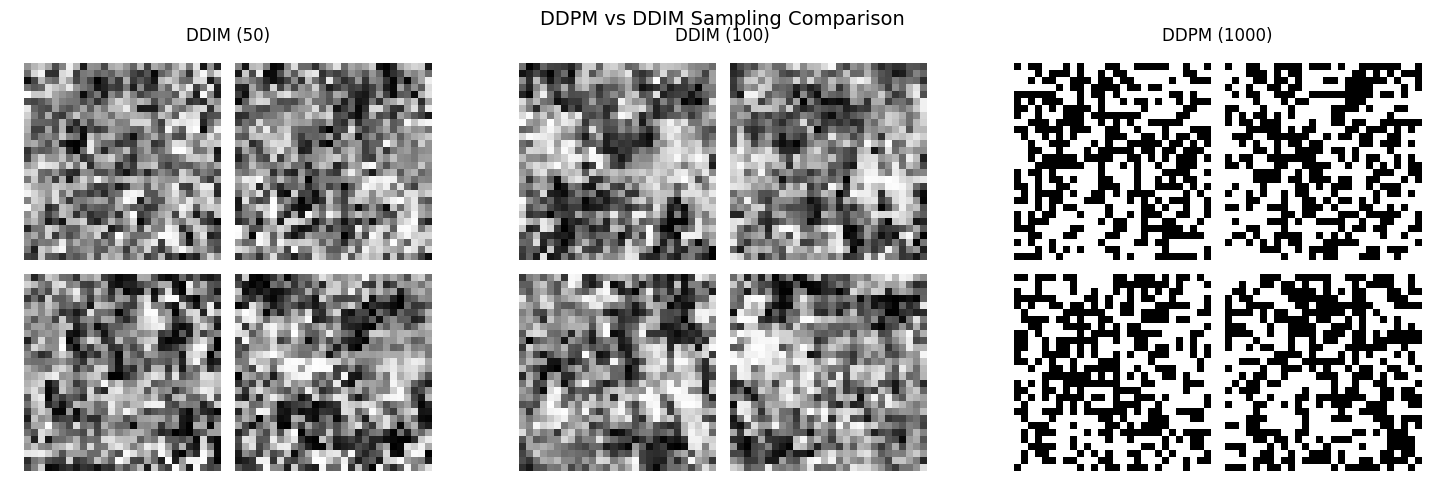

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, len(sampling_methods), figsize=(5*len(sampling_methods), 5))
if len(sampling_methods) == 1:
    axes = [axes]

for i, (method_name, samples) in enumerate(sampling_methods.items()):
    from src.utils import make_grid
    grid = make_grid(samples, nrow=2, normalize=True, value_range=(-1, 1))
    
    if grid.shape[0] == 1:
        grid_np = grid.squeeze(0).numpy()
        axes[i].imshow(grid_np, cmap='gray')
    else:
        grid_np = grid.permute(1, 2, 0).numpy()
        axes[i].imshow(grid_np)
    
    axes[i].set_title(method_name, fontsize=12)
    axes[i].axis('off')

plt.suptitle('DDPM vs DDIM Sampling Comparison', fontsize=14)
plt.tight_layout()
plt.show()


## 🎛️ Variance Schedule Comparison

Compare different variance schedules (β vs posterior variance).


Generating samples with beta variance...
Generating samples with posterior variance...


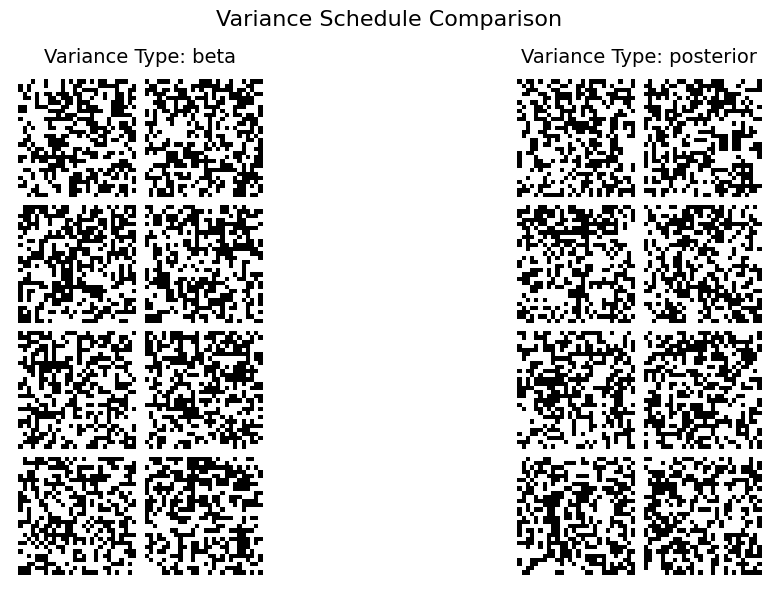

Compare the samples - do you notice differences in quality or characteristics?


In [12]:
# Generate samples with different variance schedules
variance_types = ['beta', 'posterior']
variance_samples = {}

for var_type in variance_types:
    print(f"Generating samples with {var_type} variance...")
    
    results = sampler.sample(
        shape=(8, *img_shape),
        variance_type=var_type,
        progress=False
    )
    
    variance_samples[var_type] = results['samples']

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, (var_type, samples) in enumerate(variance_samples.items()):
    # Create grid
    grid = make_grid(samples, nrow=int(np.sqrt(len(samples))), 
                    normalize=True, value_range=(-1, 1))
    
    if grid.shape[0] == 1:
        grid_np = grid.squeeze(0).numpy()
        axes[i].imshow(grid_np, cmap='gray')
    else:
        grid_np = grid.permute(1, 2, 0).numpy()
        axes[i].imshow(grid_np)
    
    axes[i].set_title(f'Variance Type: {var_type}', fontsize=14)
    axes[i].axis('off')

plt.suptitle('Variance Schedule Comparison', fontsize=16)
plt.tight_layout()
plt.show()

print("Compare the samples - do you notice differences in quality or characteristics?")


## 🎮 Interactive Exploration

Experiment with different sampling parameters.


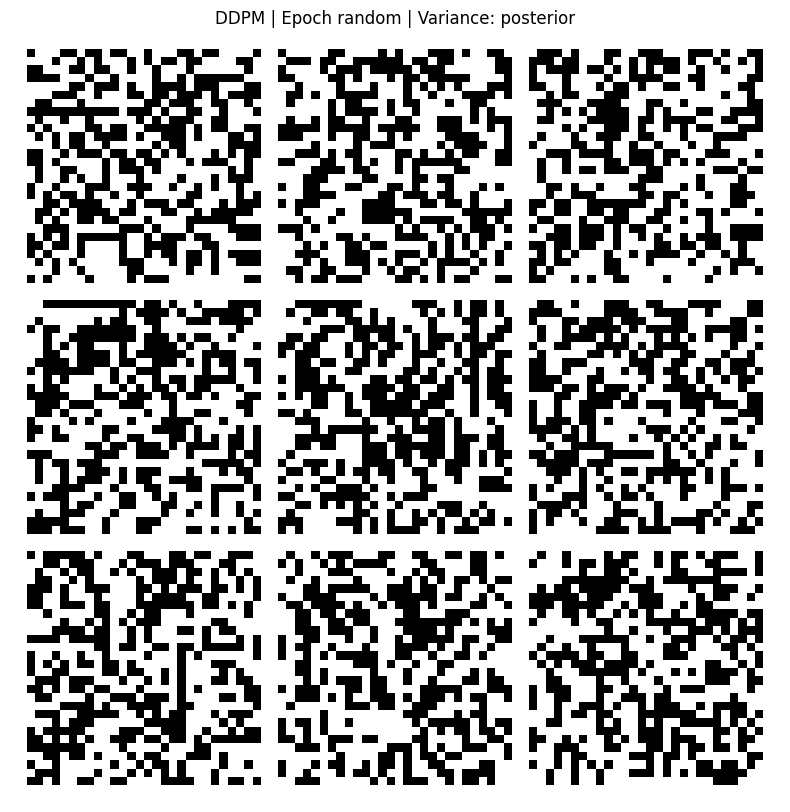

\nTry changing the parameters in the cell above to explore different settings!


In [13]:
# Interactive parameter exploration
def explore_sampling(variance_type='posterior', use_ddim=False, ddim_steps=50, num_samples=9):
    """Function to explore different sampling parameters"""
    
    # Sample
    sampling_kwargs = {
        'variance_type': variance_type,
        'progress': False
    }
    
    if use_ddim:
        sampling_kwargs.update({
            'ddim': True,
            'num_steps': ddim_steps,
            'ddim_eta': 0.0
        })
    
    results = sampler.sample(
        shape=(num_samples, *img_shape),
        **sampling_kwargs
    )
    
    # Display
    method = f"DDIM-{ddim_steps}" if use_ddim else "DDPM"
    epoch = metadata.get('epoch', 'unknown')
    title = f"{method} | Epoch {epoch} | Variance: {variance_type}"
    
    quick_grid(results['samples'], title=title, nrow=3)
    
    return results

# Example usage - modify these parameters to explore!
results = explore_sampling(
    variance_type='posterior',  # 'beta' or 'posterior'
    use_ddim=False,            # True for DDIM, False for DDPM
    ddim_steps=50,             # Only used if use_ddim=True
    num_samples=9
)

print("\\nTry changing the parameters in the cell above to explore different settings!")


## 🎉 Summary

Congratulations! You've successfully explored DDPM sampling in detail.

### Key Takeaways:
1. **Ancestral Sampling**: The step-by-step denoising process from T→0
2. **Variance Schedules**: Different σ_t options affect sample characteristics  
3. **DDIM**: Can achieve similar quality with much fewer steps
4. **Training Progress**: Sample quality typically improves with more training
5. **Interactive Exploration**: Easy to experiment with different parameters

### Next Steps:
- Try different datasets (MNIST vs CIFAR-10)
- Experiment with various checkpoint epochs (if available)
- Compare different variance schedules systematically
- Explore DDIM with different step counts
- Use the CLI tools for batch processing and evaluation

### For Production Use:
- Use the CLI scripts for batch processing: `python -m src.cli sample.grid --config configs/mnist.yaml`
- Run quality evaluation across all checkpoints: `python -m src.cli eval.quality --config configs/mnist.yaml`
- Generate trajectory animations: `python -m src.cli sample.traj --config configs/mnist.yaml`
- Create sample galleries for model comparison: `python -m src.cli compare.ckpts --config configs/mnist.yaml`


Generating final showcase samples...


DDPM Sampling: 100%|██████████| 1000/1000 [00:12<00:00, 83.28it/s, t=0, x_mean=5715.233, x_std=67815.445] 


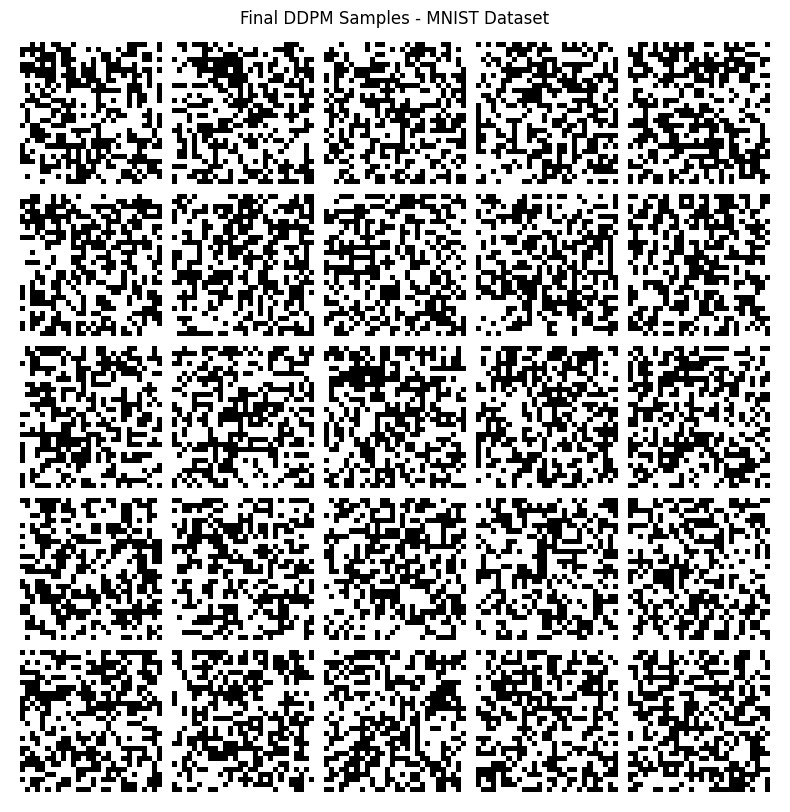

\n🎉 Day 7 DDPM Sampling Complete!
You now have a complete understanding of diffusion model sampling.


In [14]:
# Final showcase - generate a nice sample grid
print("Generating final showcase samples...")

# Generate high-quality samples
showcase_results = sampler.sample(
    shape=(25, *img_shape),  # 5x5 grid
    variance_type='posterior',
    progress=True
)

quick_grid(showcase_results['samples'], 
          title=f"Final DDPM Samples - {dataset.upper()} Dataset", 
          nrow=5)

print("\\n🎉 Day 7 DDPM Sampling Complete!")
print("You now have a complete understanding of diffusion model sampling.")
